## Regional Satellite / WRF-Chem comparison script

Bulk work, to combine data for each season, rather than plotting a single day at a time.

In [120]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib import ticker
from matplotlib import interactive
import matplotlib as mpl
interactive(True)

import xarray as xr
import numpy as np
import pandas as pd

from scipy import stats
from scipy.interpolate import griddata
import scipy

import cartopy.crs as ccrs
import colorcet as cc

from datetime import timedelta, date
import datetime

In [2]:
# date range function from stackoverflow: 
#   https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
#   (same source is used for the date range iteration below too)
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [3]:
# loads column and lat/lon data, and converts to panda array.
#    This includes copying the time index to our model data, because
#    I had not added this to the model netcdf files when creating them.
def load_create_dataframe(sat_datadask,model_datadask):

    sat_col_data = sat_datadask.column.copy(deep=True)
    sat_error_data = sat_datadask.error.copy(deep=True)
    sat_vprof_data = sat_datadask.VertProf.copy(deep=True)
    sat_clcov_data = sat_datadask.CLcov.copy(deep=True)
    sat_angle_data = sat_datadask.angle.copy(deep=True)
    lat_data = sat_datadask.latitude.copy(deep=True)
    lon_data = sat_datadask.longitude.copy(deep=True)
    
    # convert from xarray to pandas dataframe
    cold = sat_col_data.to_dataframe()
    errd = sat_error_data.to_dataframe()
    verd = sat_vprof_data.to_dataframe()
    clcd = sat_clcov_data.to_dataframe()
    angd = sat_angle_data.to_dataframe()
    latd = lat_data.to_dataframe()
    lond = lon_data.to_dataframe()
     
    # load the model data, convert to pandas
    model_nh3_data = model_datadask.nh3.copy(deep=True)
    model_date_data = model_datadask.date.copy(deep=True)
    nh3d = model_nh3_data.to_dataframe()
    dat_temp_d = model_date_data.to_dataframe()
    #dat_temp_d.column = ['full_date']
    
    # FUTURE WORK: split the date information into date and hour
    #date2d = dat_temp_d.datetime.strftime('%m/%d/%Y')
    #date2d.column = ['date']
    #hour2d = dat_temp_d.datetime.strftime('%H:%M:%S.%f')
    #hour2d.column = ['time_of_day']
    
    #result_temp = pd.concat([nh3d,dated,hourd,cold,errd,verd,clcd,angd,latd,lond], axis=1, sort=False)
    result_temp = pd.concat([dat_temp_d,nh3d,cold,errd,verd,clcd,angd,latd,lond], axis=1, sort=False)
    
    # switch index from time to date
    result = result_temp.reset_index(drop=False).set_index(['date','latitude','longitude'])

    return result

In [4]:
# Loading data files from a list.
def load_and_combine_list_of_files(satellite_file_path,model_file_path,start_date,end_date):
    
    # initalise list for storing datasets to append
    data_to_append = []  # https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop

    for single_date in daterange(start_date, end_date):
        
        date_string = single_date.strftime("%Y%m%d")+'_*'
        satellite_datadask = xr.open_mfdataset(satellite_file_path+'nh3nn_v2_2_'+date_string+'.nc')
        model_datadask = xr.open_mfdataset(model_file_path+'Ammonia_Column_'+date_string+'_gasphase_chemistry.nc')
        
        # load data for the given day
        day_data = load_create_dataframe(satellite_datadask,model_datadask)
        # get rid of empty data points, to save space!
        clean_day_data = day_data.dropna()
        
        # store DataFrame in list
        data_to_append.append(clean_day_data)
    
    
    appended_data = pd.concat(data_to_append, axis=0)
    
    return(appended_data)
    

In [5]:
# groups column data into defined lat/lon bins, takes mean value for each bin, 
#                                and returns the 2D data array of these means
def grid_satellite_model_data(dataframe,lat_bins,lon_bins,lat_mid,lon_mid):
    
    # drop NaN values, and then group into the lat/long bins
    resn = dataframe.dropna()
    #grs = dataframe.groupby([pd.cut(dataframe.latitude,lat_bins),pd.cut(dataframe.longitude,lon_bins)])
    grs = resn.groupby([pd.cut(resn.latitude,lat_bins),pd.cut(resn.longitude,lon_bins)])
    
    # get mean and count values, and reset the indexes for our dataset 
    #     - the longitude and latitude bins will now be column data rather than indexes
    grmean  = grs.column.mean().reset_index()
    grcount = grs.column.count().reset_index()
    grnh3mean = grs.nh3.mean().reset_index()
    
    # determine spatial correlation stats for each grid cell. 
    #   First create template array from mean of grouped data (without dropping lat/lon indexes)
    #   Then step through the groups, calculating the spearman stats for each (and saving info in arrays)
    #   Finally, drop the lat/lon indexes
    spear_corr = grs.column.mean()
    spear_pval = spear_corr.copy(deep=True)
    for key, group in grs:
        spear_corr.loc[(key[0].mid,key[1].mid)] = stats.spearmanr(group.column,group.nh3).correlation
        spear_pval.loc[(key[0].mid,key[1].mid)] = stats.spearmanr(group.column,group.nh3).pvalue
    spear_corr = spear_corr.reset_index()
    spear_pval = spear_pval.reset_index()
    
    
    # determine the grid centre locations from the grid information for the dataset
    grmean['Mid_Lon'] = grmean['longitude'].apply(lambda x: x.mid)
    grmean['Mid_Lat'] = grmean['latitude'].apply(lambda x: x.mid)
    grnh3mean['Mid_Lon'] = grnh3mean['longitude'].apply(lambda x: x.mid)
    grnh3mean['Mid_Lat'] = grnh3mean['latitude'].apply(lambda x: x.mid)

    # create 2D mesh for storing extracted data 
    lon_grid, lat_grid = np.meshgrid(lon_mid,lat_mid)
    
    # grid the model data (and counts)
    col_grid = griddata((grmean.Mid_Lon,grmean.Mid_Lat),grmean.column,(lon_grid,lat_grid))
    nh3_grid = griddata((grnh3mean.Mid_Lon,grnh3mean.Mid_Lat),grnh3mean.nh3,(lon_grid,lat_grid))
    count_grid = griddata((grmean.Mid_Lon,grmean.Mid_Lat),grcount.column,(lon_grid,lat_grid))
    sp_corr_grid = griddata((grmean.Mid_Lon,grmean.Mid_Lat),spear_corr.column,(lon_grid,lat_grid))
    sp_pval_grid = griddata((grmean.Mid_Lon,grmean.Mid_Lat),spear_pval.column,(lon_grid,lat_grid))
    
    return col_grid, nh3_grid, lon_grid, lat_grid, count_grid, sp_corr_grid, sp_pval_grid


#### Load satellite and model data

The 'time' index in the satellite data is 'UTC time of acquisition', in units 'HHMMSS.ms', so I think that we need to be careful to only load data for a single day at a time for this processing. Otherwise the coordinate system could become confused by duplicate values for each day. This doesn't matter for the global satellite data plots, but for this work we are merging model and satellite data, and so we need to be more careful with indexing.

In [25]:
root_path = '/Users/mbessdl2/Documents/Clearflo_data_analysis/'
satellite_file_path = root_path+'satellite_data/'
model_file_path = root_path+'model_column_data/'

# summer
start_date = date(2012, 7, 30)
end_date = date(2012, 8, 23)
#start_date = date(2012, 8, 15)
#end_date = date(2012, 8, 20)
# winter
#start_date = date(2012, 1, 8)
#end_date = date(2012, 2, 11)



In [26]:
work_data = load_and_combine_list_of_files(satellite_file_path,model_file_path,start_date,end_date)

/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:135: Fu

### Data regridding

Cleaning:
* I drop any NaN's in the data (both to zoom into the model domain, as work_data.nh3 will be NaN outside of this, and to get rid of the missing values in the satellite data, where work_data.column is a NaN). 


Mapping:
* Both model and satellite data will be mapped onto a fixed lat/lon grid, of resolution 0.5 degrees.

In [104]:
# create the edge values for our lat/lon bins
lat_bins = np.arange(36,70,2.0)
lon_bins = np.arange(-30,30,2.0)
lat_mid = np.arange(37,71,2.0)
lon_mid = np.arange(-29,31,2.0)
#lat_bins = np.arange(42,64,2.0)
#lon_bins = np.arange(-24,18,2.0)
#lat_mid = np.arange(43,65,2.0)
#lon_mid = np.arange(-25,19,2.0)
#lat_bins = np.arange(44,60,1.0)
#lon_bins = np.arange(-20,15,1.0)
#lat_mid = np.arange(44.5,60.5,1.0)
#lon_mid = np.arange(-20.5,15.5,1.0)
#lat_bins = np.arange(44,60,0.5)
#lon_bins = np.arange(-20,15,0.5)
#lat_mid = np.arange(44.25,60.25,0.5)
#lon_mid = np.arange(-20.25,15.25,0.5)

wdata = work_data.reset_index(level=[1,2])

sat_grid, mod_grid, lon_grid, lat_grid, test_count, sp_corr, sp_pval = grid_satellite_model_data(wdata,lat_bins,lon_bins,lat_mid,lon_mid)


### Data plotting

Plotting of model vs satellite relationship, for the subgroups defined above.

First set of plots is without weighting by the satellite errors, second set of plots is with this weighting.

In each plot the linear correlation line is given, along with dashed lines indicating the bounds of the one standard deviation uncertainty in slope and intercept.



/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


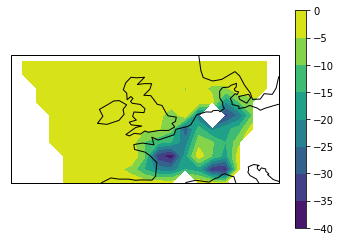

In [53]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#plt.contourf(lon_grid,lat_grid,test_grid,locator=ticker.LogLocator(),vmin=1e14,vmax=1e17)
#plt.contourf(lon_grid,lat_grid,test_grid,locator=ticker.LogLocator(subs=(1.,2.,5.))
#plt.contourf(lon_grid,lat_grid,sat_grid,locator=ticker.LogLocator())
#plt.contourf(lon_grid,lat_grid,sat_grid)
#plt.contourf(lon_grid,lat_grid,sp_corr)
plt.contourf(lon_grid,lat_grid,np.log10(sp_pval))
#plt.contourf(lon_grid,lat_grid,test_count)
plt.colorbar()

/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


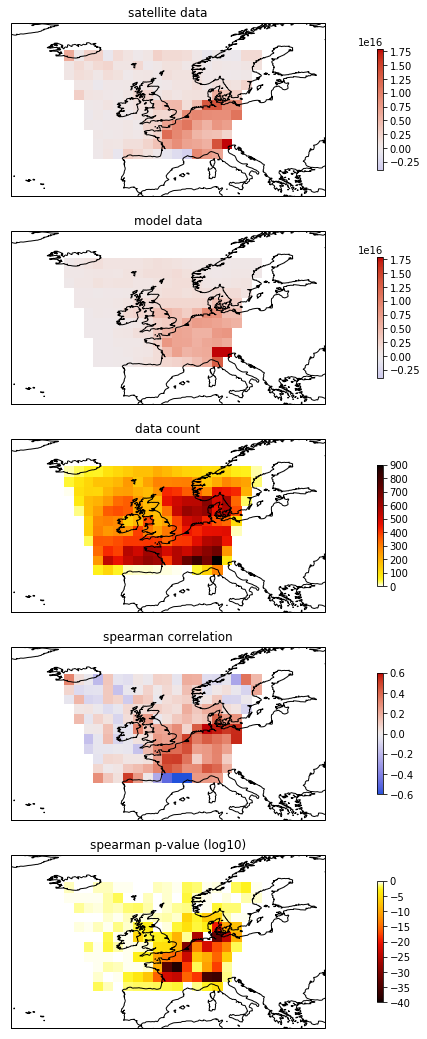

In [133]:
def map_plot(data,lon_g,lat_g,ax_ind,titlestring,plt,clim,plim,cmap):
    ax = plt.subplot(ax_ind[0], ax_ind[1], ax_ind[2], projection=ccrs.PlateCarree())
    #ax = plt.subplot(ax_ind[0], ax_ind[1], ax_ind[2], projection=ccrs.LambertConformal(central_longitude=-2.417999,central_latitude=53.915))
    ax.coastlines('50m')
    #ax.coastlines()


    cf = ax.pcolormesh(lon_g,lat_g,data,vmin=clim[0],vmax=clim[1],cmap=cmap)
    ax.set_title(titlestring)

    # colormap control code taken from here: https://stackoverflow.com/questions/3373256/set-colorbar-range-in-matplotlib
    ax_cbar, _ = mpl.colorbar.make_axes(ax, shrink=0.7)
    cbar = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap, norm=mpl.colors.Normalize(vmin=plim[0],vmax=plim[1]))
    cbar.set_clim(clim[0],clim[1])
    
    
    
    
plt.figure(figsize=(18.5, 18.5))
map_plot(sat_grid,lon_grid,lat_grid,[5,1,1],"satellite data",plt,[-1.8e16,1.8e16],[-0.4e16,1.8e16],cc.cm.coolwarm)
map_plot(mod_grid,lon_grid,lat_grid,[5,1,2],"model data",plt,[-1.8e16,1.8e16],[-0.4e16,1.8e16],cc.cm.coolwarm)
map_plot(test_count,lon_grid,lat_grid,[5,1,3],"data count",plt,[0,900],[0,900],cc.cm.fire_r)
map_plot(sp_corr,lon_grid,lat_grid,[5,1,4],"spearman correlation",plt,[-0.6,0.6],[-0.6,0.6],cc.cm.coolwarm)
map_plot(np.log10(sp_pval),lon_grid,lat_grid,[5,1,5],"spearman p-value (log10)",plt,[-40,0],[-40,0],cc.cm.fire)



In [99]:
plt.subplot?

In [112]:
cc.cm.coolwarm